In [79]:
import pandas as pd
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [57]:
combined_data = pd.read_parquet('combined_data.parquet')
print("Columns with NaN values:")
print(combined_data.isnull().sum())
combined_data_clean = combined_data.dropna()

Columns with NaN values:
patient_id         0
event              0
T                  0
sex                0
race               0
ethnicity          0
min_travel_time    0
SDOH               0
education          0
income             0
mi                 0
chf                0
pvd                0
cevd               0
dementia           0
copd               0
rheumd             0
pud                0
mld                0
msld               0
diab               0
dia_w_c            0
hp                 0
mrend              0
srend              0
aids               0
hiv                0
mst                0
mal                0
Obesity            0
WL                 0
Alcohol            0
Drug               0
Psycho             0
Dep                0
dtype: int64


In [70]:
def custom_print_summary(cph, all_covariates, excluded_covariates):
    """
    customized print summary function
    """
    original_summary = cph.summary

    new_summary = pd.DataFrame(index=all_covariates, 
                               columns=original_summary.columns, 
                               data=pd.NA)

    included_covariates = [cov for cov in all_covariates if cov not in excluded_covariates]
    for cov in included_covariates:
        if cov in original_summary.index:
            new_summary.loc[cov] = original_summary.loc[cov]

    print("=== Custom CoxPHFitter Summary ===")
    print(new_summary.to_string())
    print("\n=== Model Statistics ===")
    print(f"Concordance Index: {cph.concordance_index_:.3f}")
    print(f"Partial AIC: {cph.AIC_partial_:.1f}")
    print(f"Log-likelihood ratio test: {cph.log_likelihood_ratio_test().test_statistic:.2f}")


In [71]:
def check_group_sizes(data, categorical_cols):
    """
    Check if any group has less than 20 samples
    Returns a dict of problematic groups and their counts
    """
    
    min_size = 20  
    small_groups = {}
    
    # Check categorical variables
    for col in categorical_cols:
        counts = data[col].value_counts()
        small_cats = counts[counts < min_size]
        if len(small_cats) > 0:
            small_groups[col] = small_cats.to_dict()
            
    # Check binary disease indicators
    disease_cols = ['mi', 'chf', 'pvd', 'cevd', 'dementia', 'copd', 'rheumd', 'pud', 
    'mld', 'msld', 'diab', 'dia_w_c', 'hp', 'mrend', 'srend', 
    'aids', 'hiv', 'mst', 'mal', 'Obesity', 'WL', 'Alcohol', 'Drug', 'Psycho', 'Dep']
    for col in disease_cols:
        if col in data.columns:
            counts = data[col].value_counts()
            if 1 in counts and counts[1] < 20:
                small_groups[col] = {'positive_cases': counts[1]}
                
    return small_groups

def run_cox_analysis_with_privacy(data, enforce_privacy=True):
    """
    Run Cox analysis with optional privacy enforcement
    
    Parameters:
    data: DataFrame with the required columns
    enforce_privacy: If True, exclude groups with n<20
    
    Returns:
    model: Fitted CoxPHFitter model
    excluded_groups: Dict of groups excluded due to small sample size
    """
    # Travel Time
    travel_covariates = ['min_travel_time']
    
    # Demographics
    demo_covariates = [col for col in data.columns if col.startswith(('sex_', 'race_', 'ethnicity_'))]
    
    # Comorbidity
    charlson_covariates = [
    'mi', 'chf', 'pvd', 'cevd', 'dementia', 'copd', 'rheumd', 'pud', 
    'mld', 'msld', 'diab', 'dia_w_c', 'hp', 'mrend', 'srend', 
    'aids', 'hiv', 'mst', 'mal', 'Obesity', 'WL', 'Alcohol', 'Drug', 'Psycho', 'Dep'
    ]
    
    # SDOH
    sdoh_covariates = [col for col in data.columns 
                      if col.startswith('education_')] + ['SDOH']
    
    all_covariates = travel_covariates + demo_covariates + charlson_covariates + sdoh_covariates
    
    if enforce_privacy:
        small_groups = check_group_sizes(data, demo_covariates)
        excluded_covariates = list(small_groups.keys())
        included_covariates = [cov for cov in all_covariates if cov not in excluded_covariates]
    else:
        small_groups = {}
        excluded_covariates = []
        included_covariates = all_covariates  # Use all covariates when privacy is not enforced

    # Use all covariates plus outcome columns
    cox_data = data[included_covariates + ['T', 'event']].copy()

    # Fit Cox model
    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(cox_data, duration_col='T', event_col='event')

    return cph, small_groups, excluded_covariates, all_covariates

def generate_analysis_report(data, model, excluded_groups=None):
    """Generate a comprehensive analysis report"""
    report = []
    
    # Basic statistics
    report.append("=== Basic Statistics ===")
    report.append(f"Total patients: {len(data)}")
    report.append(f"Event distribution:\n{data['event'].value_counts().to_string()}")
    report.append(f"\nTime variable statistics:\n{data['T'].describe().to_string()}")
    
    # Excluded groups (if privacy check was enforced)
    if excluded_groups:
        report.append("\n=== Excluded Groups (n<20) ===")
        for col, groups in excluded_groups.items():
            report.append(f"{col}: {groups}")
    
    # Model summary statistics
    report.append("\n=== Model Summary ===")
    report.append(f"Concordance: {model.concordance_index_:.3f}")
    report.append(f"Partial AIC: {model.AIC_partial_:.1f}")
    report.append(f"Log-likelihood ratio test: {model.log_likelihood_ratio_test().test_statistic:.2f}")
    
    # Significant covariates (p < 0.05)
    report.append("\n=== Significant Covariates (p < 0.05) ===")
    summary_df = model.print_summary().summary
    sig_covariates = summary_df[summary_df['p'] < 0.05]
    if len(sig_covariates) > 0:
        report.append(sig_covariates.to_string())
    else:
        report.append("No significant covariates found at p < 0.05 level")
    
    return "\n".join(report)



In [72]:
# read data
data = pd.read_parquet('combined_data.parquet')

# version 1：with privacy
print("\n=== version 1: with privacy check ===")
model_with_privacy, excluded_groups, excluded_covs, all_covs = run_cox_analysis_with_privacy(data, enforce_privacy=True)
custom_print_summary(model_with_privacy, all_covs, excluded_groups.keys())

print("\nCox Summary (privacy):")
model_with_privacy.print_summary()




=== version 1: with privacy check ===
=== Custom CoxPHFitter Summary ===
                     coef exp(coef)  se(coef) coef lower 95% coef upper 95% exp(coef) lower 95% exp(coef) upper 95% cmp to         z         p  -log2(p)
min_travel_time -0.003964  0.996044  0.003894      -0.011597       0.003669             0.98847            1.003676    0.0 -1.017868  0.308741  1.695533
mi                   <NA>      <NA>      <NA>           <NA>           <NA>                <NA>                <NA>   <NA>      <NA>      <NA>      <NA>
chf                  <NA>      <NA>      <NA>           <NA>           <NA>                <NA>                <NA>   <NA>      <NA>      <NA>      <NA>
pvd                  <NA>      <NA>      <NA>           <NA>           <NA>                <NA>                <NA>   <NA>      <NA>      <NA>      <NA>
cevd                 <NA>      <NA>      <NA>           <NA>           <NA>                <NA>                <NA>   <NA>      <NA>      <NA>      <NA>
dementia

<lifelines.CoxPHFitter: fitted with 100 total observations, 49 right-censored observations>
             duration col = 'T'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 100
number of events observed = 51
   partial log-likelihood = -185.51
         time fit was run = 2025-02-20 06:59:38 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
min_travel_time -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
SDOH            -0.00      1.00      0.06           -0.12            0.11                0.89                1.12

                 cmp to     z    p  -log2(p)
covariate                                   
min_travel_time    0.00 -1.02 0.31      1.70
SDOH               0.00 -0.04 0.97      0.04
---
Concordance = 0.57
Partial AIC = 375.01
log-likelihood ratio test = 1.06 on 2 df
-log2(p) of ll-ratio test = 0.76

In [80]:
# version 2：no privacy 
print("\n=== version 2: without privacy check ===")
model_without_privacy, small_groups, excluded_covs, all_covs = run_cox_analysis_with_privacy(data, enforce_privacy=False)
print("\nCox Summary (no privacy):")

custom_print_summary(model_without_privacy, all_covs, [])

model_without_privacy.print_summary()


=== version 2: without privacy check ===

Cox Summary (no privacy):
=== Custom CoxPHFitter Summary ===
                     coef exp(coef)  se(coef) coef lower 95% coef upper 95% exp(coef) lower 95% exp(coef) upper 95% cmp to         z         p  -log2(p)
min_travel_time -0.005076  0.994937  0.004526      -0.013947       0.003794             0.98615            1.003801    0.0 -1.121642  0.262015   1.93228
mi              -0.351158  0.703872  0.697883      -1.718984       1.016668            0.179248             2.76397    0.0 -0.503176  0.614841  0.701716
chf              0.115701   1.12266    0.6687      -1.194927       1.426328            0.302726            4.163383    0.0  0.173023  0.862633  0.213181
pvd               -0.7917  0.453074  0.958579       -2.67048        1.08708            0.069219            2.965603    0.0  -0.82591  0.408855  1.290338
cevd            -0.032201  0.968311  0.730922      -1.464783        1.40038            0.231128            4.056739    0.0 -0.04405

<lifelines.CoxPHFitter: fitted with 100 total observations, 49 right-censored observations>
             duration col = 'T'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 100
number of events observed = 51
   partial log-likelihood = -175.63
         time fit was run = 2025-02-20 07:07:48 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
min_travel_time -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
mi              -0.35      0.70      0.70           -1.72            1.02                0.18                2.76
chf              0.12      1.12      0.67           -1.19            1.43                0.30                4.16
pvd             -0.79      0.45      0.96           -2.67            1.09                0.07                2.97
cevd            -0.03      0.97      0.73           -1.46            1.40                0.23                4.06
dementia        -0.93      0.39      0.66           -2.23            0.37                0.11                1.44
copd            -0.14      0.87      0.56           -1.24            0.96                0.29                2.61
rheumd          -0.76      0.47      0.82           -2.38            0.85                0.09                2.34
pud              0.59      1.80      0.65           -0.69            1.86                0.50                6.43
mld              0.54      1.72      0.78           -0.99            2.08                0.37                7.97
msld             0.25      1.28      0.94           -1.59            2.09                0.20                8.08
diab            -0.57      0.57      0.59           -1.72            0.58                0.18                1.78
dia_w_c          0.70      2.02      0.66           -0.59            1.99                0.55                7.32
hp              -0.57      0.57      0.58           -1.70            0.56                0.18                1.75
mrend            0.54      1.71      0.60           -0.64            1.72                0.53                5.57
srend           -1.19      0.30      0.74           -2.64            0.26                0.07                1.30
aids             1.08      2.95      1.03           -0.93            3.10                0.39               22.15
hiv              0.50      1.64      0.79           -1.05            2.04                0.35                7.72
mst              0.08      1.08      0.91           -1.70            1.86                0.18                6.44
mal              0.71      2.04      0.60           -0.46            1.88                0.63                6.54
Obesity          0.41      1.51      0.74           -1.04            1.86                0.35                6.43
WL               0.56      1.74      1.01           -1.42            2.54                0.24               12.64
Alcohol          0.27      1.31      0.76           -1.22            1.76                0.29                5.83
Drug            -0.04      0.96      1.30           -2.58            2.51                0.08               12.29
Psycho          -0.39      0.68      0.83           -2.02            1.24                0.13                3.46
Dep              1.20      3.33      0.82           -0.41            2.82                0.66               16.71
SDOH             0.02      1.02      0.07           -0.12            0.16                0.89                1.17

                 cmp to     z    p  -log2(p)
covariate                                   
min_travel_time    0.00 -1.12 0.26      1.93
mi                 0.00 -0.50 0.61      0.70
chf                0.00  0.17 0.86      0.21
pvd                0.00 -0.83 0.41      1.29
cevd   

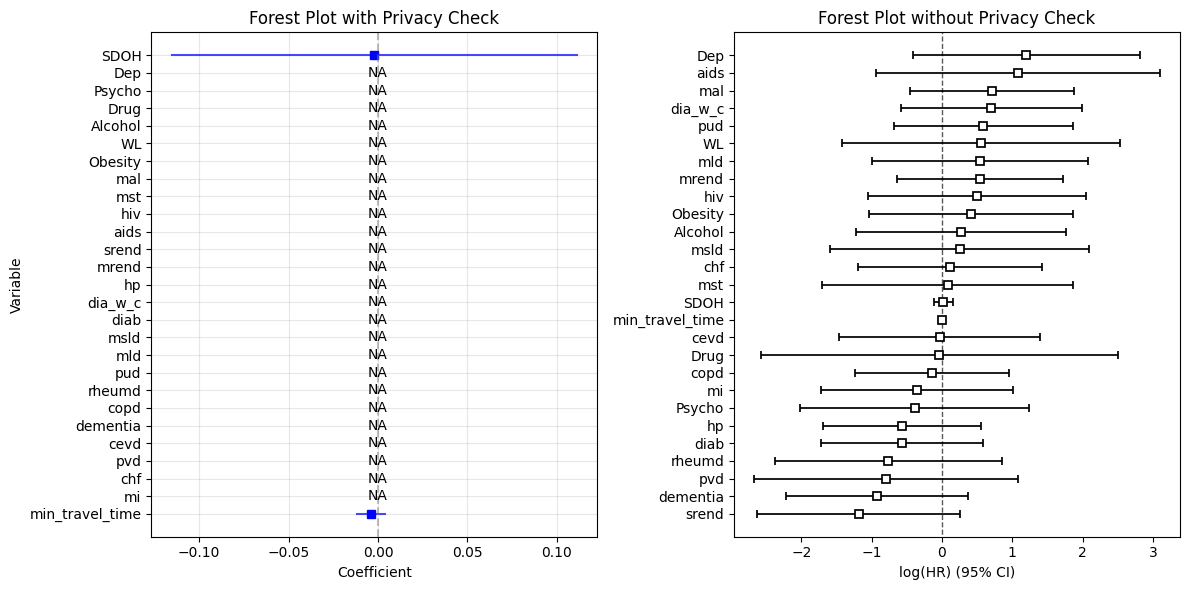


=== Model Comparison ===
With privacy check:
Concordance Index: 0.572
Log-likelihood ratio test: 1.06

Without privacy check:
Concordance Index: 0.716
Log-likelihood ratio test: 20.81


In [81]:
def plot_forest_with_privacy(model_with_privacy, model_without_privacy, excluded_covariates=None, ax=None):
    """
    Create a forest plot displaying “NA” for variables excluded due to privacy checks.
    
    model_with_privacy: CoxPHFitter model with privacy checks applied.
	model_without_privacy: CoxPHFitter model without privacy checks.
	excluded_covariates: List of covariates excluded due to privacy reasons.
	ax: Matplotlib axis object (optional).
    """
    
    if ax is None:
        ax = plt.gca()
    
    if excluded_covariates is None:
        excluded_covariates = []
    
    all_covariates = model_without_privacy.summary.index.tolist()
    
    summary = model_with_privacy.summary
    plot_data = pd.DataFrame(index=all_covariates,
                           columns=['coef', 'exp(coef)', 'se(coef)', 
                                  'coef lower 95%', 'coef upper 95%'])
    
    for var in all_covariates:
        if var not in excluded_covariates and var in summary.index:
            plot_data.loc[var] = summary.loc[var]
    
    ypos = range(len(all_covariates))
    
    for i, var in enumerate(all_covariates):
        if not pd.isna(plot_data.loc[var, 'coef']):
            ax.plot([plot_data.loc[var, 'coef lower 95%'],
                    plot_data.loc[var, 'coef upper 95%']], 
                   [i, i], 'b-', alpha=0.7)
            ax.plot(plot_data.loc[var, 'coef'], i, 'bs')
        else:
            ax.text(0, i, 'NA', va='center', ha='center')
    
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_yticks(ypos)
    ax.set_yticklabels(all_covariates)
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Variable')
    ax.grid(True, alpha=0.3)
    
    return ax

model_with_privacy, small_groups, excluded_covariates, all_covariates = run_cox_analysis_with_privacy(data, enforce_privacy=True)
model_without_privacy, _, _, _ = run_cox_analysis_with_privacy(data, enforce_privacy=False)

plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
plot_forest_with_privacy(model_with_privacy, model_without_privacy, excluded_covariates, ax=ax1)
plt.title('Forest Plot with Privacy Check')

ax2 = plt.subplot(122)
model_without_privacy.plot(ax=ax2)
plt.title('Forest Plot without Privacy Check')

plt.tight_layout()
plt.show()

# Print comparison results
print("\n=== Model Comparison ===")
print("With privacy check:")
print(f"Concordance Index: {model_with_privacy.concordance_index_:.3f}")
print(f"Log-likelihood ratio test: {model_with_privacy.log_likelihood_ratio_test().test_statistic:.2f}")
print("\nWithout privacy check:")
print(f"Concordance Index: {model_without_privacy.concordance_index_:.3f}")
print(f"Log-likelihood ratio test: {model_without_privacy.log_likelihood_ratio_test().test_statistic:.2f}")
